# Tarea 2 - Redes Neuronales Recurrentes (RNNs)

## Parte 1: Detección de Spam

In [1]:
import torch
import random
import time
import matplotlib.pyplot as plt
from torch import nn
from torchtext.legacy import data

# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Text learning setup
SEED = 1999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.long, batch_first=True)

### Actividad 1

Se utilizará el embedding **GloVe (Global Vectors)** para las oraciones del set de entrada. Este embedding mezcla ideas de **Word2Vec** para obtener la información local entre grupos de palabras, con ideas de **LSA (Latent Semantic Analysis)** para obtener información a nivel global en el dataset. Se basa en la matriz de co-ocurrencia de las palabras dentro del dataset, buscando derivar relaciones semánticas no implícitas dentro de cada oración. Posteriormente se aplica un modelo logarítmico bilinear que intenta minimizar cuadrados, logrando mapear estas relaciones entre palabras a relaciones similares entre los vectores resultantes que se asocian a cada palabra.

Para comenzar, se genera el dataset de textos de **SMS** y labels **(ham, spam)** a partir del archivo entregado:

In [2]:
# Build dataset from tsv file
spam_dataset = data.TabularDataset(
    path='spam_dataset/spam', 
    format='tsv', 
    fields=[('label', LABEL), ('text', TEXT)])

Como el dataset no viene separado, se deben generar manualmente los sets de entrenamiento, validación y testing:

In [3]:
# Divide between training/validation/testing (70/15/15 split)
train_data, valid_data, test_data = spam_dataset.split(split_ratio=[0.7, 0.15, 0.15], random_state=random.seed(SEED))

print(len(train_data), len(valid_data), len(test_data))

3902 836 836


A continuación se construye el vocabulario utilizando el embedding GloVe (versión de 100 componentes) y el set de entrenamiento:

In [4]:
# Build vocabulary with the GloVe embedding
TEXT.build_vocab(train_data, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

Se puede observar que el vocabulario tiene un tamaño de 9539, donde entre las palabras más frecuentes se encuentran "to", "I", "you":

In [5]:
# Quick look at the vocabulary
print(len(TEXT.vocab))
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

9539
[('.', 3486), ('to', 1488), ('I', 1395), (',', 1333), ('you', 1284), ('?', 1006), ('!', 947), ('a', 937), ('the', 827), ('...', 785), ('i', 693), ('and', 625), ('in', 577), ('is', 567), ('u', 542), ('me', 533), ('..', 464), ('for', 446), ('my', 424), ('it', 423)]
['<unk>', '<pad>', '.', 'to', 'I', ',', 'you', '?', '!', 'a']
defaultdict(None, {'ham': 0, 'spam': 1})


Finalmente, se definen los iteradores que cargarán los datos al momento de entrenar y evaluar el modelo. Para ello se utilizan batches de tamaño 64 y el **BucketIterator**, que permite minimizar el padding realizado sobre cada batch (junta oraciones de largo similar): 

In [6]:
# Define iterators for the data
batch_size = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

### Actividad 2

Ahora se define el modelo de la RNN a utilizar para este problema. Se crea una clase que permite instanciar modelos con RNN tanto simples como de tipo **LSTM (Long Short Term Memory)**, permitiendo ajustar la dimensionalidad de entrada, embedding, capas ocultas, capa densa y salida. Además, es posible elegir el número de capas y si la red es bidireccional:

In [7]:
# Recurrent Neural Network
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=1, 
                 lstm=False, bidirectional=False, dropout=0.5, pad_idx=None):
        super().__init__()
        
        # Model information
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.n_directions = 1
        if bidirectional:
            self.n_directions = 2
        
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        
        # Dropout settings
        dropout_value = 0
        if num_layers > 1:
            dropout_value = dropout
        
        # RNN type (Normal/LSTM)
        self.lstm = lstm
        if lstm:
            self.rnn = nn.LSTM(embedding_dim, 
                              hidden_dim, 
                              num_layers=num_layers, 
                              bidirectional=bidirectional, 
                              dropout=dropout_value,
                              batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, 
                              hidden_dim, 
                              num_layers=num_layers, 
                              bidirectional=bidirectional, 
                              dropout=dropout_value,
                              batch_first=True)

        # Dense layers for classification
        self.dense = nn.Linear(hidden_dim * self.n_directions, dense_dim)
        self.linear_out = nn.Linear(dense_dim, output_dim)
    
    # Forward pass of the RNN
    def forward(self, text, text_lengths):
        # Pad sequence
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True)
        
        # RNN type
        if self.lstm:
            packed_output, (hidden, cell) = self.rnn(packed_embedded)
        else:
            packed_output, hidden = self.rnn(packed_embedded)
        
        # Final state
        hidden = hidden.view(self.num_layers, self.n_directions, text.shape[0], self.hidden_dim)[-1]
          
        # Directions
        if self.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden.squeeze(0)
        
        # Dense layer
        dense = self.dense(hidden)
        return self.linear_out(dense)

# Check the number of trainable parameters in a model
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Se instancia el modelo para una RNN simple con los parámetros pedidos, y con el output de tamaño 2 (ham y spam), para que más adelante sea posible aplicar la función SoftMax:

In [8]:
# Simple RNN model
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 80
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

simple_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, pad_idx=pad_idx)
print(f'Trainable Parameters: {num_trainable_parameters(simple_model)}')

Trainable Parameters: 973442


Podemos observar que el modelo tiene 973442 parámetros entrenables. Este número **depende del dataset**, puesto que si se cambia la cantidad de palabras del vocabulario, la capa de embedding también cambiará su dimensionalidad y su cantidad de parámetros (independiente de la dimensionalidad de salida de la capa). Si se quisiera reducir la cantidad de parámetros sin modificar la dimensionalidad del estado interno, se podría reducir la cantidad de neuronas de la capa densa (actualmente 60), así como también disminuir la dimensionalidad de los vectores del embedding y/o el tamaño del vocabulario generado.

In [9]:
# Simple RNN model with less params
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 80
dense_dim = 6
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

simple_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, pad_idx=pad_idx)
print(f'Trainable Parameters: {num_trainable_parameters(simple_model)}')

Trainable Parameters: 968960


En este caso se redujo el número de parámetros simplemente disminuyendo el tamaño de la capa densa. Ahora se vuelve al modelo original, pero aumentando la dimensionalidad del estado oculto de la red a 120:

In [18]:
# Simple RNN model with more params
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 120
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

simple_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, pad_idx=pad_idx)
print(f'Trainable Parameters: {num_trainable_parameters(simple_model)}')

Trainable Parameters: 987922


Como era de esperar, la cantidad de parámetros aumenta junto con el tamaño de las capas ocultas, debido a que se tienen más pesos intermedios que ajustar al momento de moverse dentro de la red por cada palabra de cada frase.

Se completa el modelo cargando los pesos de los vectores pre-entrenados por el método GloVe:

In [19]:
# Load embedding data for GloVe into the model
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
simple_model.embedding.weight.data.copy_(pretrained_embeddings)

# Special indexes are replaced with zeros
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
simple_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
simple_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
print(simple_model.embedding.weight.data)

torch.Size([9539, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])


### Actividad 3

Se definen funciones de utilidad para entrenar y testear el modelo por épocas, guardando las métricas de pérdida y precisión:

In [12]:
# Round the output value to binary values
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    _, pred_labels = torch.max(rounded_preds, dim=1)
    correct = (pred_labels == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train for one epoch
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  # Training mode
    for batch in iterator:
        # Reset gradients & predict
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        
        # Compute loss & accuracy, run backprop and update weights
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        # Metrics
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Test for one epoch
def test(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  # Eval mode
    with torch.no_grad():
        for batch in iterator:
            # Get predictions
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            
            # Compute loss & accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            # Metrics
            epoch_loss += loss.item()
            epoch_acc += acc.item()   
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Run training
def run_training(model, train_iterator, val_iterator, optimizer, criterion, n_epochs):
    history = {
        'train': {'acc': [], 'loss': []},
        'val': {'acc': [], 'loss': []}}

    best_valid_loss = float('inf')
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Train one epoch
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = test(model, valid_iterator, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # Save best state for model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'spam.pt')
        
        # Display information
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
        # Save metrics history
        history['train']['acc'].append(round(train_acc, 2))
        history['train']['loss'].append(round(train_loss, 2))
        history['val']['acc'].append(round(valid_acc, 2))
        history['val']['loss'].append(round(valid_loss, 2))
    return history

# Run testing
def run_testing(model, test_iterator, criterion, state):
    model.load_state_dict(torch.load(state))
    test_loss, test_acc = test(model, test_iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    return round(test_acc, 2), round(test_loss, 2)

Se utiliza el criterio de **CrossEntropyLoss** para calcular la pérdida, el que aplica la función de activación **SoftMax** automáticamente:

In [20]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 20
lr = 0.001

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=lr)

# Model & Criterion to GPU
simple_model = simple_model.to(device)
criterion = criterion.to(device)

Entrenamos el modelo durante 10 épocas:

In [21]:
# Run training
train_history = run_training(simple_model, train_iterator, valid_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.327 | Train Acc: 87.27%
	 Val. Loss: 0.244 |  Val. Acc: 90.40%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.172 | Train Acc: 93.70%
	 Val. Loss: 0.139 |  Val. Acc: 95.31%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.090 | Train Acc: 97.08%
	 Val. Loss: 0.117 |  Val. Acc: 95.65%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.050 | Train Acc: 98.72%
	 Val. Loss: 0.093 |  Val. Acc: 97.77%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.031 | Train Acc: 99.31%
	 Val. Loss: 0.192 |  Val. Acc: 95.54%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.020 | Train Acc: 99.41%
	 Val. Loss: 0.115 |  Val. Acc: 97.10%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.022 | Train Acc: 99.46%
	 Val. Loss: 0.113 |  Val. Acc: 97.10%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.005 | Train Acc: 99.87%
	 Val. Loss: 0.124 |  Val. Acc: 97.43%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.024 | Train Acc: 99.18%
	 Val. Loss: 0.118 |  Val. Acc: 97.66%
Epoch: 10 | Epoch Time: 0m 0

Se grafica la precisión a lo largo del entrenamiento:

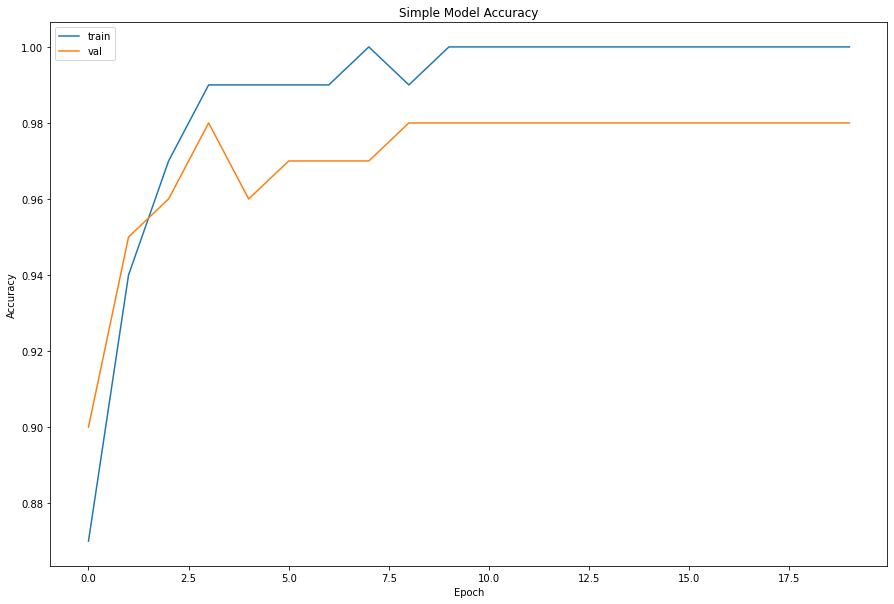

In [22]:
# History for epoch accuracy
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['acc'])
plt.plot(train_history['val']['acc'])
plt.title('Simple Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Podemos ver que el set de validación alcanza su mejor puntaje alrededor de la tercera época, mientras que el de entrenamiento sigue mejorando hasta llegar al 100%. Esto significa que ocurre **overfitting** desde la tercera época en adelante. Ahora se grafica la pérdida a lo largo del entrenamiento:

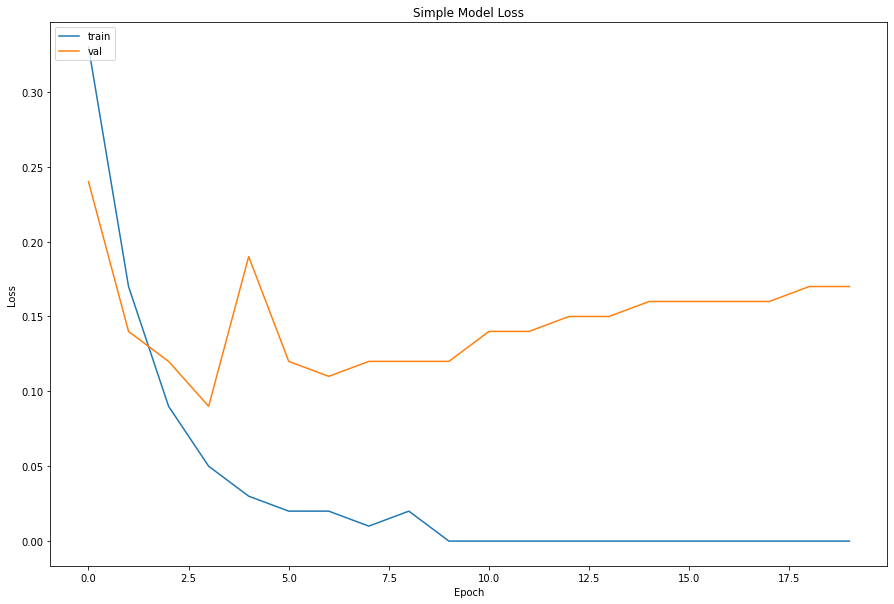

In [23]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['loss'])
plt.plot(train_history['val']['loss'])
plt.title('Simple Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Al igual que con la precisión, se observa overfitting después de la tercera época. Finalmente, se evalúa el modelo entrenado sobre el set de testing:

In [24]:
# Run testing
test_acc, test_loss = run_testing(simple_model, test_iterator, criterion, 'spam.pt')

Test Loss: 0.092 | Test Acc: 97.43%


Obtenemos una **precisión del 97.43%,** lo que es muy bueno en términos del desempeño de nuestro modelo, especialmente al ser una RNN simple.

### Actividad 4

Instanciamos un modelo **LSTM** con las mismas dimensiones que el anterior:

In [31]:
# Simple LSTM model
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 120
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

lstm_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, lstm=True, pad_idx=pad_idx)
print(f'Trainable Parameters: {num_trainable_parameters(lstm_model)}')

Trainable Parameters: 1067842


La cantidad de parámetros de este modelo es 1067842, superando al anterior en alrededor de un 2%. Esto no afecta mucho al momento de entrenar, ya que es un aumento pequeño en la cantidad de parámetros. Ahora se realizan los mismos pasos que antes para preparar y entrenar el modelo:

In [32]:
# Load embedding data for GloVe into the model
lstm_model.embedding.weight.data.copy_(pretrained_embeddings)

# Special indexes are replaced with zeros
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
lstm_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
lstm_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
print(lstm_model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])


In [33]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 20
lr = 0.001

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

# Model & Criterion to GPU
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [34]:
# Run training
train_history = run_training(lstm_model, train_iterator, valid_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.330 | Train Acc: 86.73%
	 Val. Loss: 0.244 |  Val. Acc: 87.61%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.150 | Train Acc: 93.67%
	 Val. Loss: 0.226 |  Val. Acc: 93.97%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.067 | Train Acc: 97.90%
	 Val. Loss: 0.078 |  Val. Acc: 98.21%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.040 | Train Acc: 98.98%
	 Val. Loss: 0.120 |  Val. Acc: 95.65%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.027 | Train Acc: 99.46%
	 Val. Loss: 0.084 |  Val. Acc: 98.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.021 | Train Acc: 99.46%
	 Val. Loss: 0.062 |  Val. Acc: 98.44%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.028 | Train Acc: 99.26%
	 Val. Loss: 0.269 |  Val. Acc: 92.19%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.013 | Train Acc: 99.69%
	 Val. Loss: 0.077 |  Val. Acc: 98.55%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.004 | Train Acc: 99.95%
	 Val. Loss: 0.091 |  Val. Acc: 98.66%
Epoch: 10 | Epoch Time: 0m 0

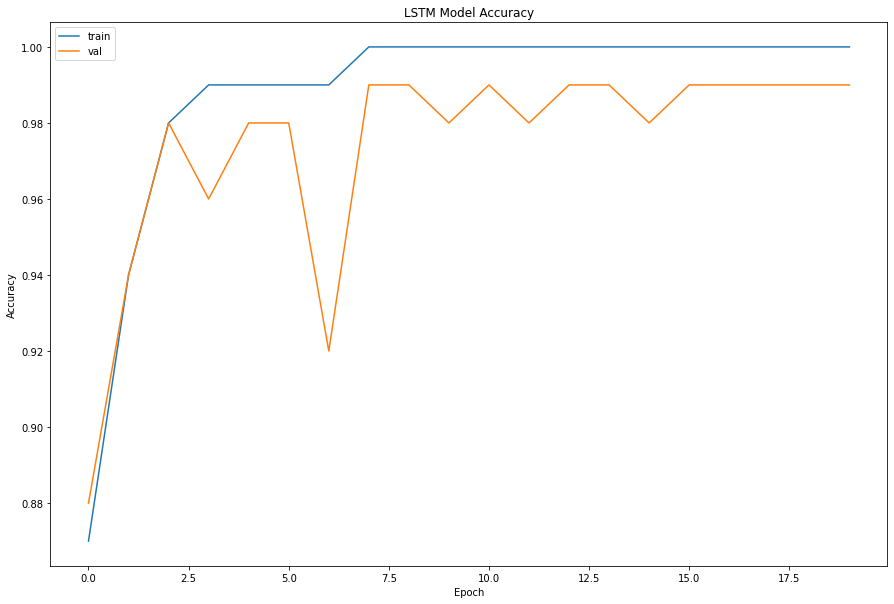

In [35]:
# History for epoch accuracy
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['acc'])
plt.plot(train_history['val']['acc'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

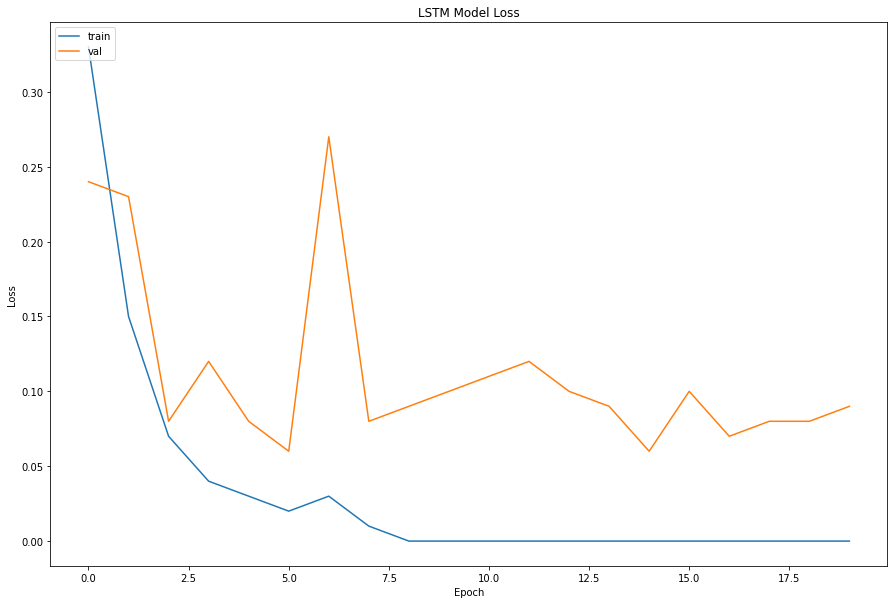

In [36]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['loss'])
plt.plot(train_history['val']['loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
# Run testing
test_acc, test_loss = run_testing(lstm_model, test_iterator, criterion, 'spam.pt')

Test Loss: 0.053 | Test Acc: 98.55%


Se obtienen resultados favorables, con una precisión del **98.55%**. Además, el overfitting ocurre más adelante esta vez, alrededor de la época 7, lo que demuestra que este modelo se logra ajustar mejor al caso general, aunque requiera más épocas de entrenamiento.

### Actividad 5

Utilizaremos el modelo LSTM anterior, que fue el que mejor rindió. Primero probamos agregando una capa más a la red:

In [38]:
# LSTM model with two layers
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 120
dense_dim = 60
output_dim = 2
num_layers = 2
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

best_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, lstm=True, dropout=0, pad_idx=pad_idx)
print(f'Trainable Parameters: {num_trainable_parameters(best_model)}')

Trainable Parameters: 1184002


Ocurre un aumento pequeño en la cantidad de parámetros, llegando a 1184002.

In [39]:
# Load embedding data for GloVe into the model
best_model.embedding.weight.data.copy_(pretrained_embeddings)

# Special indexes are replaced with zeros
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
best_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
best_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
print(best_model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])


In [40]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 20
lr = 0.001

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)

# Model & Criterion to GPU
best_model = best_model.to(device)
criterion = criterion.to(device)

In [41]:
# Run training
train_history = run_training(best_model, train_iterator, valid_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.363 | Train Acc: 86.73%
	 Val. Loss: 0.226 |  Val. Acc: 87.39%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.168 | Train Acc: 92.67%
	 Val. Loss: 0.161 |  Val. Acc: 97.43%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.091 | Train Acc: 97.28%
	 Val. Loss: 0.084 |  Val. Acc: 98.21%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.044 | Train Acc: 98.92%
	 Val. Loss: 0.082 |  Val. Acc: 98.55%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.032 | Train Acc: 99.26%
	 Val. Loss: 0.074 |  Val. Acc: 97.99%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.032 | Train Acc: 99.33%
	 Val. Loss: 0.058 |  Val. Acc: 98.77%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.016 | Train Acc: 99.67%
	 Val. Loss: 0.057 |  Val. Acc: 99.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.011 | Train Acc: 99.80%
	 Val. Loss: 0.054 |  Val. Acc: 98.88%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.87%
	 Val. Loss: 0.074 |  Val. Acc: 98.66%
Epoch: 10 | Epoch Time: 0m 0

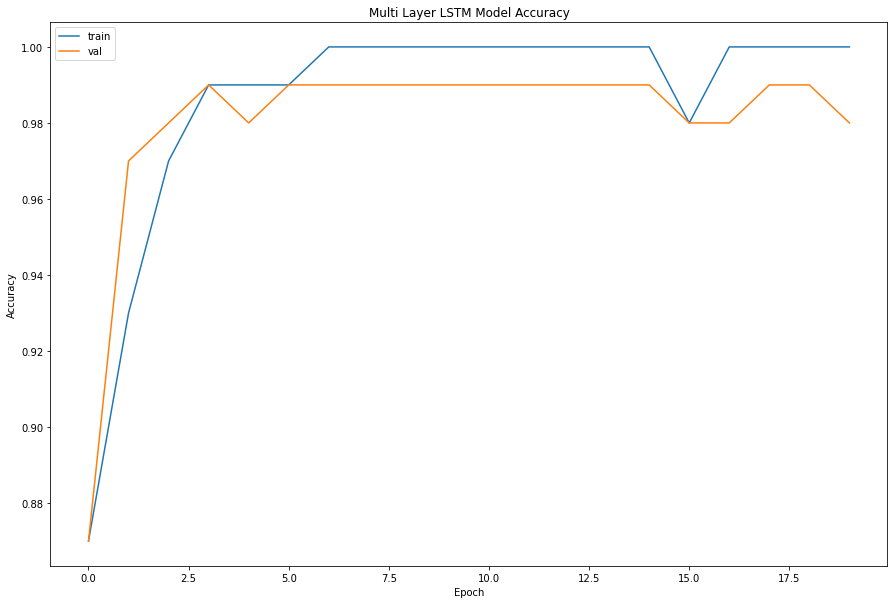

In [42]:
# History for epoch accuracy
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['acc'])
plt.plot(train_history['val']['acc'])
plt.title('Multi Layer LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

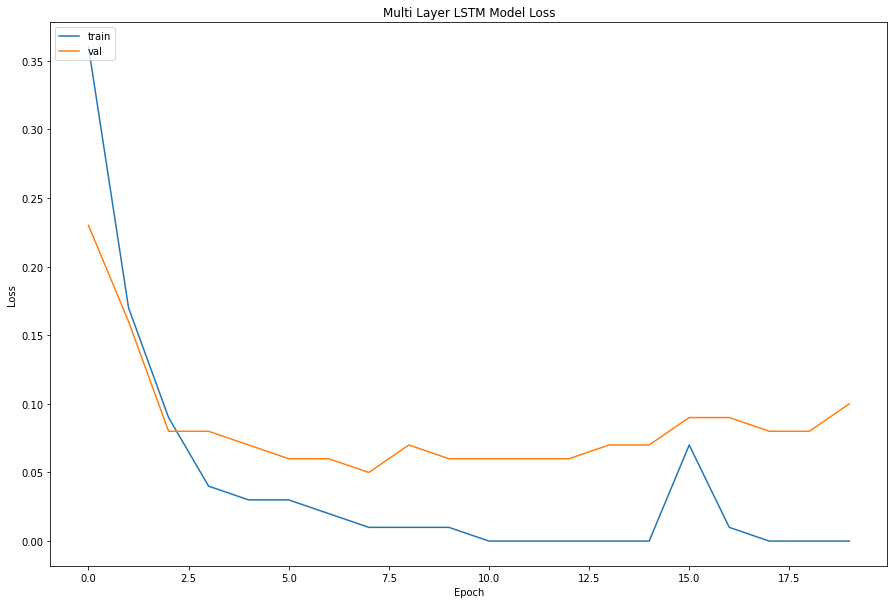

In [43]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['loss'])
plt.plot(train_history['val']['loss'])
plt.title('Multi Layer LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
# Run testing
test_acc, test_loss = run_testing(best_model, test_iterator, criterion, 'spam.pt')

Test Loss: 0.058 | Test Acc: 98.77%


Se logra una precisión un poco mejor que antes, con un **98.77%**. El modelo converge un poco más rápido que su contraparte de una sola capa, gracias a que tiene mayor información en sus capas ocultas. Ahora se prueba volviendo al modelo anterior, pero con la capa **bidireccional**, cambiando las dimensiones del embedding a vectores de 200 componentes y disminuyendo la cantidad de neuronas de la capa densa a 20:

In [45]:
# LSTM bidirectional model
input_dim = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 120
dense_dim = 20
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

best_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, lstm=True, bidirectional=True, dropout=0, pad_idx=pad_idx)
print(f'Trainable Parameters: {num_trainable_parameters(best_model)}')

Trainable Parameters: 2221782


Ocurre un gran aumento en la cantidad de parámetros, duplicando a los anteriores. Esto es debido a que se duplicó el tamaño de los vectores de salida de la capa de embedding, además de que ahora la red tiene 2 direcciones.

In [46]:
# Build vocabulary with the GloVe embedding for 200D
TEXT.build_vocab(train_data, vectors='glove.6B.200d', unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:25<00:00, 15979.38it/s]


In [47]:
# Quick look at the new vocabulary
print(len(TEXT.vocab))
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

9539
[('.', 3486), ('to', 1488), ('I', 1395), (',', 1333), ('you', 1284), ('?', 1006), ('!', 947), ('a', 937), ('the', 827), ('...', 785), ('i', 693), ('and', 625), ('in', 577), ('is', 567), ('u', 542), ('me', 533), ('..', 464), ('for', 446), ('my', 424), ('it', 423)]
['<unk>', '<pad>', '.', 'to', 'I', ',', 'you', '?', '!', 'a']
defaultdict(None, {'ham': 0, 'spam': 1})


In [48]:
# Load embedding data for GloVe 200D into the model
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
best_model.embedding.weight.data.copy_(pretrained_embeddings)

# Special indexes are replaced with zeros
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
best_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
best_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
print(best_model.embedding.weight.data)

torch.Size([9539, 200])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1229,  0.5804, -0.0696,  ..., -0.0392, -0.1624, -0.0967],
        ...,
        [ 0.2340, -0.0039, -0.0155,  ..., -0.1764, -0.1381,  0.0127],
        [ 0.2013,  0.2142, -0.0443,  ..., -0.0237, -0.0541,  0.3707],
        [-0.7439, -0.5804,  1.1561,  ..., -1.4570,  1.3810, -0.5698]])


In [49]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 20
lr = 0.001

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)

# Model & Criterion to GPU
best_model = best_model.to(device)
criterion = criterion.to(device)

In [50]:
# Run training
train_history = run_training(best_model, train_iterator, valid_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.283 | Train Acc: 87.14%
	 Val. Loss: 0.134 |  Val. Acc: 96.09%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.083 | Train Acc: 97.23%
	 Val. Loss: 0.058 |  Val. Acc: 98.10%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.027 | Train Acc: 98.92%
	 Val. Loss: 0.069 |  Val. Acc: 97.99%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.012 | Train Acc: 99.64%
	 Val. Loss: 0.048 |  Val. Acc: 98.55%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.72%
	 Val. Loss: 0.058 |  Val. Acc: 98.55%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.72%
	 Val. Loss: 0.094 |  Val. Acc: 96.76%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.004 | Train Acc: 99.90%
	 Val. Loss: 0.045 |  Val. Acc: 98.77%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 99.97%
	 Val. Loss: 0.045 |  Val. Acc: 98.66%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.001 | Train Acc: 99.97%
	 Val. Loss: 0.044 |  Val. Acc: 98.77%
Epoch: 10 | Epoch Time: 0m 0

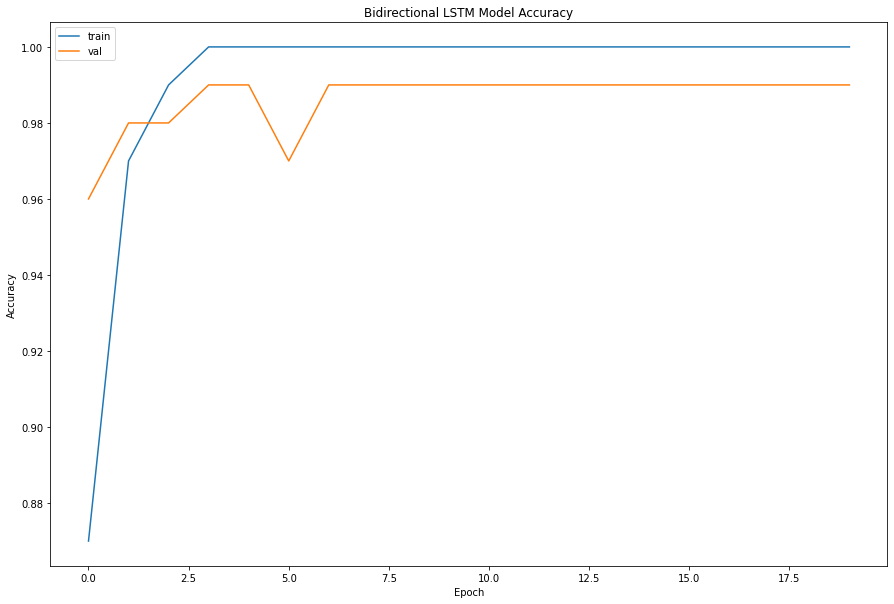

In [51]:
# History for epoch accuracy
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['acc'])
plt.plot(train_history['val']['acc'])
plt.title('Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

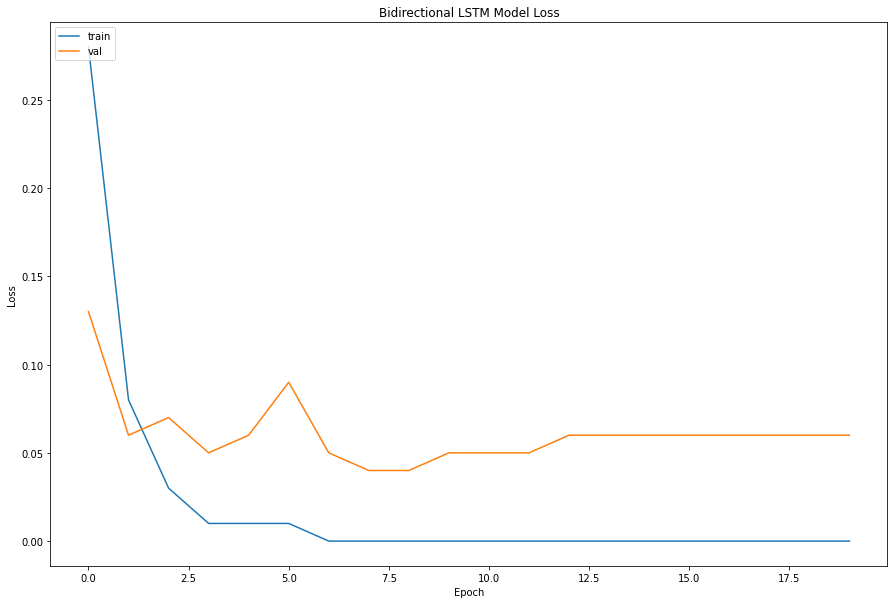

In [52]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['loss'])
plt.plot(train_history['val']['loss'])
plt.title('Bidirectional LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
# Run testing
test_acc, test_loss = run_testing(best_model, test_iterator, criterion, 'spam.pt')

Test Loss: 0.075 | Test Acc: 98.33%


El rendimiento del modelo es un poco peor que el de doble capa, pero la velocidad de convergencia es mayor, logrando ajustarse en tan solo 3 épocas. Se concluye que la bidireccionalidad agrega bastante valor a una red de este tipo, siempre y cuando se ajusten bien los hiper-parámetros tales como la dimensionalidad del embedding y de la capa densa.

## Parte 2: Aprendizaje de Similitud entre Oraciones

In [118]:
import torch
import random
import time
import matplotlib.pyplot as plt
from torch import nn
from torchtext.legacy import data
from gensim.models import KeyedVectors

# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Text learning setup
SEED = 1999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True, batch_first=True)
SCORE = data.Field(sequential=False, use_vocab=False, dtype=torch.float, is_target=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.long, batch_first=True)
SET = data.LabelField(dtype=torch.long, batch_first=True)

### Dataset y Embedding

In [282]:
# Build training dataset from tsv file
train_data = data.TabularDataset(
    path='sick_dataset/SICK.txt', 
    format='tsv', 
    fields=[
        ('pair_ID', None), 
        ('sentence_A', TEXT), 
        ('sentence_B', TEXT), 
        ('entailment_label', LABEL),
        ('relatedness_score', SCORE),
        ('entailment_AB', None),
        ('entailment_BA', None),
        ('sentence_A_original', None),
        ('sentence_B_original', None),
        ('sentence_A_dataset', None),
        ('sentence_B_dataset', None),
        ('SemEval_set', SET)],
    skip_header=True)

# Filter train examples
train_data.examples = [e for e in train_data if e.SemEval_set == 'TRAIN']
train_data.fields['SemEval_set'] = None
print(f'Size: {len(train_data)}')

Size: 4439


In [170]:
# Build validation dataset from tsv file
valid_data = data.TabularDataset(
    path='sick_dataset/SICK.txt', 
    format='tsv', 
    fields=[
        ('pair_ID', None), 
        ('sentence_A', TEXT), 
        ('sentence_B', TEXT), 
        ('entailment_label', LABEL),
        ('relatedness_score', SCORE),
        ('entailment_AB', None),
        ('entailment_BA', None),
        ('sentence_A_original', None),
        ('sentence_B_original', None),
        ('sentence_A_dataset', None),
        ('sentence_B_dataset', None),
        ('SemEval_set', SET)],
    skip_header=True)

# Filter validation examples
valid_data.examples = [e for e in valid_data if e.SemEval_set == 'TRIAL']
valid_data.fields['SemEval_set'] = None
print(f'Size: {len(valid_data)}')

Size: 495


In [171]:
# Build testing dataset from tsv file
test_data = data.TabularDataset(
    path='sick_dataset/SICK.txt', 
    format='tsv', 
    fields=[
        ('pair_ID', None), 
        ('sentence_A', TEXT), 
        ('sentence_B', TEXT), 
        ('entailment_label', LABEL),
        ('relatedness_score', SCORE),
        ('entailment_AB', None),
        ('entailment_BA', None),
        ('sentence_A_original', None),
        ('sentence_B_original', None),
        ('sentence_A_dataset', None),
        ('sentence_B_dataset', None),
        ('SemEval_set', SET)],
    skip_header=True)

# Filter testing examples
test_data.examples = [e for e in test_data if e.SemEval_set == 'TEST']
test_data.fields['SemEval_set'] = None
print(f'Size: {len(test_data)}')

Size: 4906


In [122]:
# Word2Vec embedding
word2vec = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
weights = torch.FloatTensor(word2vec.vectors)
mapping = word2vec.key_to_index

In [283]:
# Build vocabulary with the Word2Vec embedding
TEXT.build_vocab(train_data)
TEXT.vocab.set_vectors(mapping, weights, weights.shape[1])
LABEL.build_vocab(train_data)

In [284]:
# Quick look at the vocabulary
print(len(TEXT.vocab))
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

2252
[('is', 8126), ('a', 7132), ('A', 5196), ('the', 3054), ('man', 2479), ('in', 2268), ('and', 2041), ('are', 1728), ('on', 1704), ('The', 1598), ('woman', 1310), ('of', 1136), ('dog', 1089), ('playing', 1040), ('with', 946), ('Two', 557), ('by', 554), ('no', 553), ('person', 542), ('There', 533)]
['<unk>', '<pad>', 'is', 'a', 'A', 'the', 'man', 'in', 'and', 'are']
defaultdict(None, {'NEUTRAL': 0, 'ENTAILMENT': 1, 'CONTRADICTION': 2})


In [285]:
# Define iterators for the data
batch_size = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=batch_size,
    sort_key=lambda x: len(x.sentence_A + x.sentence_B),
    sort_within_batch=True,
    device=device)

### Actividad 6

In [175]:
# Siamese RNN
class Siamese(nn.Module):
    def __init__(self, hidden_dim, embedding):
        super().__init__()
        
        # Model information
        self.input_dim = len(embedding)
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        unk_idx = embedding.stoi[TEXT.unk_token]
        pad_idx = embedding.stoi[TEXT.pad_token]
        self.embedding = nn.Embedding.from_pretrained(embedding.vectors, padding_idx=pad_idx)
        self.embedding_dim = embedding.vectors.shape[1]
        self.embedding.weight.data[unk_idx] = torch.zeros(self.embedding_dim)
        self.embedding.weight.data[pad_idx] = torch.zeros(self.embedding_dim)
        
        # LSTM networks
        self.lstm_1 = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_dim,
            bidirectional=True,
            batch_first=True)
        self.lstm_2 = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_dim,
            bidirectional=True,
            batch_first=True)

    # Calculate similarity
    def similarity(self, x1, x2):
        return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=1)) * 5
    
    # Forward pass of the siamese RNN
    def forward(self, text_a, length_a, text_b, length_b):
        # Embedding
        embedded_a = self.embedding(text_a)
        embedded_b = self.embedding(text_b)
        
        # Pad sequence
        packed_a = nn.utils.rnn.pack_padded_sequence(embedded_a, length_a.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_b = nn.utils.rnn.pack_padded_sequence(embedded_b, length_b.to('cpu'), batch_first=True, enforce_sorted=False)
        
        # Pass through LSTM networks
        packed_out_a, (hidden_a, cell) = self.lstm_1(packed_a)
        packed_out_b, (hidden_b, cell) = self.lstm_2(packed_b)
        
        # Concatenate both directions
        hidden_a = torch.cat((hidden_a[-2,:,:], hidden_a[-1,:,:]), dim=1)
        hidden_b = torch.cat((hidden_b[-2,:,:], hidden_b[-1,:,:]), dim=1)
        
        # Calculate similarity score
        scores = self.similarity(hidden_a, hidden_b)
        return scores

# Check the number of trainable parameters in a model
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [201]:
# Siamese RNN
embedding_vocab = TEXT.vocab
hidden_dim = 50

siamese_model = Siamese(hidden_dim, embedding_vocab)
print(f'Trainable Parameters: {num_trainable_parameters(siamese_model)}')

Trainable Parameters: 281600


### Actividad 7

In [177]:
# Calculate accuracy based on similarity threshold
def threshold_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    true_pos = 0
    true_neg = 0
    for actual, predict in zip(y, rounded_preds):
        if (predict >= 2.5 and actual >= 2.5):
            true_pos += 1
        elif (predict < 2.5 and actual < 2.5):
            true_neg += 1
    correct = true_pos + true_neg
    acc = correct / len(y)
    return acc

# Calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train for one epoch
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  # Training mode
    for batch in iterator:
        # Reset gradients & predict
        optimizer.zero_grad()
        text_a, length_a = batch.sentence_A
        text_b, length_b = batch.sentence_B
        scores = model(text_a, length_a, text_b, length_b)
        
        # Compute loss & accuracy, run backprop and update weights
        loss = criterion(scores, batch.relatedness_score)
        acc = threshold_accuracy(scores, batch.relatedness_score)
        loss.backward()
        optimizer.step()
        
        # Metrics
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Test for one epoch
def test(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  # Eval mode
    with torch.no_grad():
        for batch in iterator:
            # Get predictions         
            text_a, length_a = batch.sentence_A
            text_b, length_b = batch.sentence_B
            scores = model(text_a, length_a, text_b, length_b)
            
            # Compute loss & accuracy
            loss = criterion(scores, batch.relatedness_score)
            acc = threshold_accuracy(scores, batch.relatedness_score)

            # Metrics
            epoch_loss += loss.item()
            epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Run training
def run_training(model, train_iterator, val_iterator, optimizer, criterion, n_epochs):
    history = {
        'train': {'acc': [], 'loss': []},
        'val': {'acc': [], 'loss': []}}

    best_valid_loss = float('inf')
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Train one epoch
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = test(model, valid_iterator, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # Save best state for model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'sick.pt')
        
        # Display information
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
        # Save metrics history
        history['train']['acc'].append(round(train_acc, 2))
        history['train']['loss'].append(round(train_loss, 2))
        history['val']['acc'].append(round(valid_acc, 2))
        history['val']['loss'].append(round(valid_loss, 2))
    return history

# Run testing
def run_testing(model, test_iterator, criterion, state):
    model.load_state_dict(torch.load(state))
    test_loss, test_acc = test(model, test_iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    return round(test_acc, 2), round(test_loss, 2)

In [202]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 50
lr = 0.003

# Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=lr)

# Model & Criterion to GPU
siamese_model = siamese_model.to(device)
criterion = criterion.to(device)

In [203]:
# Run training
train_history = run_training(siamese_model, train_iterator, valid_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 4.585 | Train Acc: 51.29%
	 Val. Loss: 1.299 |  Val. Acc: 79.11%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.959 | Train Acc: 84.20%
	 Val. Loss: 1.069 |  Val. Acc: 82.71%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.745 | Train Acc: 87.52%
	 Val. Loss: 0.979 |  Val. Acc: 83.90%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.646 | Train Acc: 89.31%
	 Val. Loss: 0.945 |  Val. Acc: 84.41%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 90.18%
	 Val. Loss: 0.913 |  Val. Acc: 85.19%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.543 | Train Acc: 91.00%
	 Val. Loss: 0.929 |  Val. Acc: 84.80%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.505 | Train Acc: 91.52%
	 Val. Loss: 0.903 |  Val. Acc: 86.24%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.472 | Train Acc: 92.25%
	 Val. Loss: 0.898 |  Val. Acc: 85.46%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.449 | Train Acc: 92.57%
	 Val. Loss: 0.914 |  Val. Acc: 85.78%
Epoch: 10 | Epoch Time: 0m 1

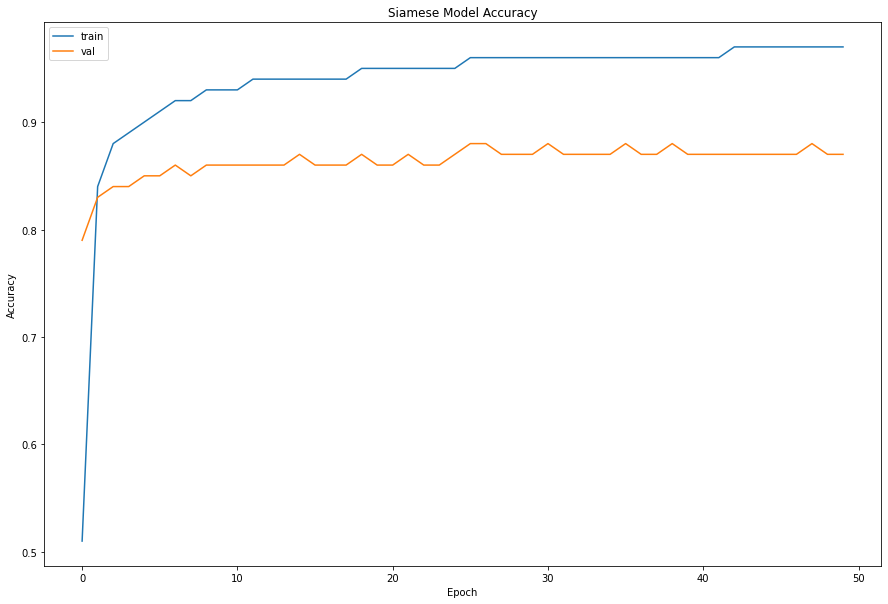

In [204]:
# History for epoch accuracy
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['acc'])
plt.plot(train_history['val']['acc'])
plt.title('Siamese Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

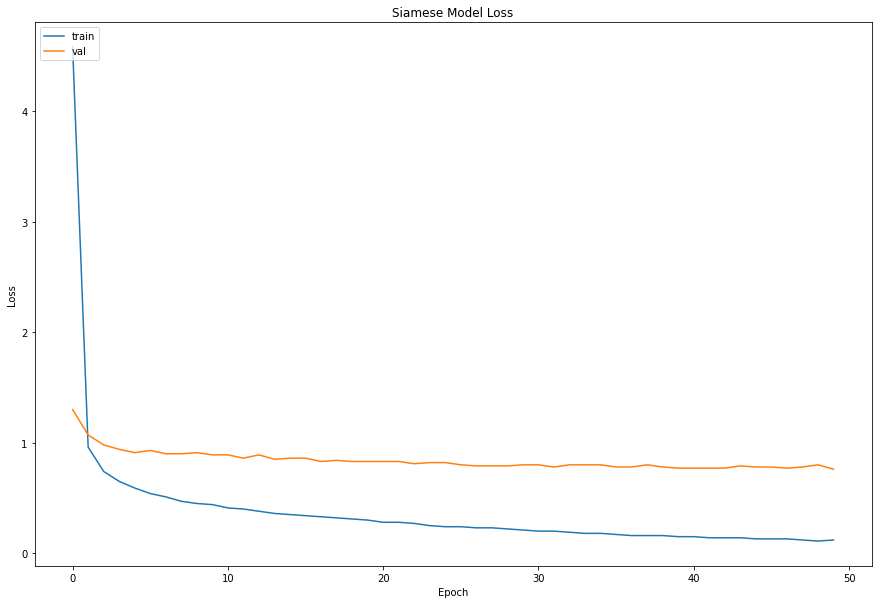

In [205]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['loss'])
plt.plot(train_history['val']['loss'])
plt.title('Siamese Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [206]:
# Run testing
test_acc, test_loss = run_testing(siamese_model, test_iterator, criterion, 'sick.pt')

Test Loss: 0.701 | Test Acc: 88.37%


### Actividad 8

In [286]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Ignore stop words
stop_words = set(stopwords.words('english'))

# Get synonyms for a specific word
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = ''.join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

# Add synonyms of most frequent words randomly
def synonym_insertion(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.lower() not in stop_words]))
    most_common = [w for (w, c) in TEXT.vocab.freqs.most_common(50)]
    random_word_freq = [w for w in random_word_list if w in most_common]
    random.shuffle(random_word_list)
    num_added = 0
    
    # Replace with synonyms
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            for word_pos in range(len(new_words)):
                if new_words[word_pos] == random_word:
                    new_words.insert(word_pos, synonym)
                    num_added += 1
                    break
        
        if num_added >= n: # Only add up to n words
            break
    return new_words

In [287]:
# Data augmentation
for example in train_data:
    example.sentence_A = synonym_insertion(example.sentence_A, 1)
    example.sentence_B = synonym_insertion(example.sentence_B, 1)

In [288]:
# Build new vocabulary with the augmented data
TEXT.build_vocab(train_data)
TEXT.vocab.set_vectors(mapping, weights, weights.shape[1])

In [289]:
# Quick look at the vocabulary
print(len(TEXT.vocab))
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

5065
[('is', 8126), ('a', 7132), ('A', 5196), ('the', 3054), ('man', 2479), ('in', 2268), ('and', 2041), ('are', 1728), ('on', 1718), ('The', 1598), ('woman', 1310), ('of', 1136), ('dog', 1093), ('playing', 1044), ('with', 946), ('Two', 557), ('by', 556), ('no', 553), ('person', 549), ('There', 533)]
['<unk>', '<pad>', 'is', 'a', 'A', 'the', 'man', 'in', 'and', 'are']
defaultdict(None, {'NEUTRAL': 0, 'ENTAILMENT': 1, 'CONTRADICTION': 2})


In [290]:
# Define new iterators for the data
batch_size = 64

train_iterator = data.BucketIterator(
    train_data, 
    batch_size=batch_size,
    sort_key=lambda x: len(x.sentence_A + x.sentence_B),
    sort_within_batch=True,
    device=device)

In [291]:
# Augmented Siamese RNN
embedding_vocab = TEXT.vocab
hidden_dim = 50

aug_model = Siamese(hidden_dim, embedding_vocab)

In [292]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 50
lr = 0.003

# Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=lr)

# Model & Criterion to GPU
aug_model = aug_model.to(device)
criterion = criterion.to(device)

In [293]:
# Run training
train_history = run_training(aug_model, train_iterator, valid_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 4.897 | Train Acc: 47.34%
	 Val. Loss: 1.275 |  Val. Acc: 79.97%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.053 | Train Acc: 82.26%
	 Val. Loss: 1.020 |  Val. Acc: 82.78%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.796 | Train Acc: 86.90%
	 Val. Loss: 0.943 |  Val. Acc: 84.48%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.671 | Train Acc: 89.24%
	 Val. Loss: 0.900 |  Val. Acc: 85.07%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.596 | Train Acc: 90.27%
	 Val. Loss: 0.856 |  Val. Acc: 85.65%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.541 | Train Acc: 91.25%
	 Val. Loss: 0.860 |  Val. Acc: 86.83%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.507 | Train Acc: 91.81%
	 Val. Loss: 0.837 |  Val. Acc: 86.63%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.471 | Train Acc: 92.12%
	 Val. Loss: 0.817 |  Val. Acc: 87.29%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.451 | Train Acc: 92.21%
	 Val. Loss: 0.817 |  Val. Acc: 87.29%
Epoch: 10 | Epoch Time: 0m 1

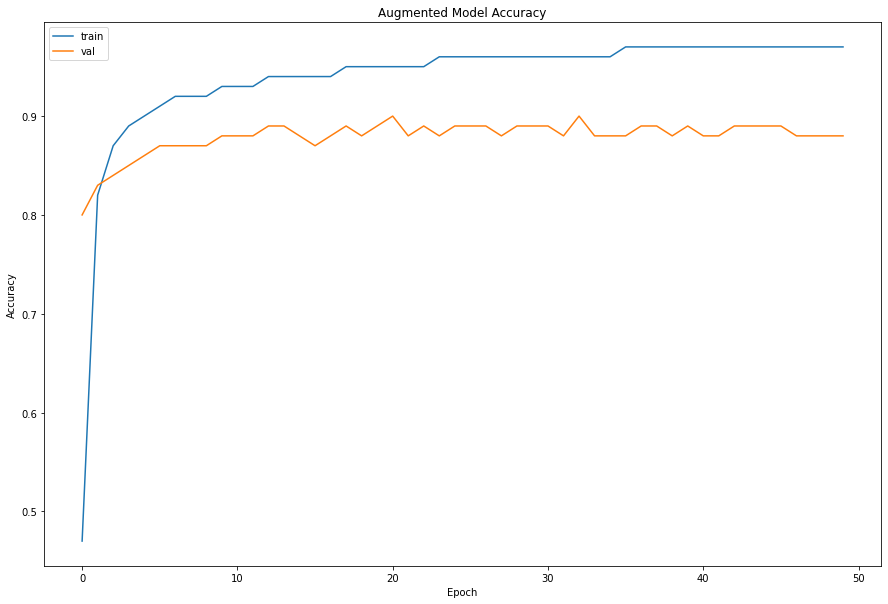

In [294]:
# History for epoch accuracy
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['acc'])
plt.plot(train_history['val']['acc'])
plt.title('Augmented Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

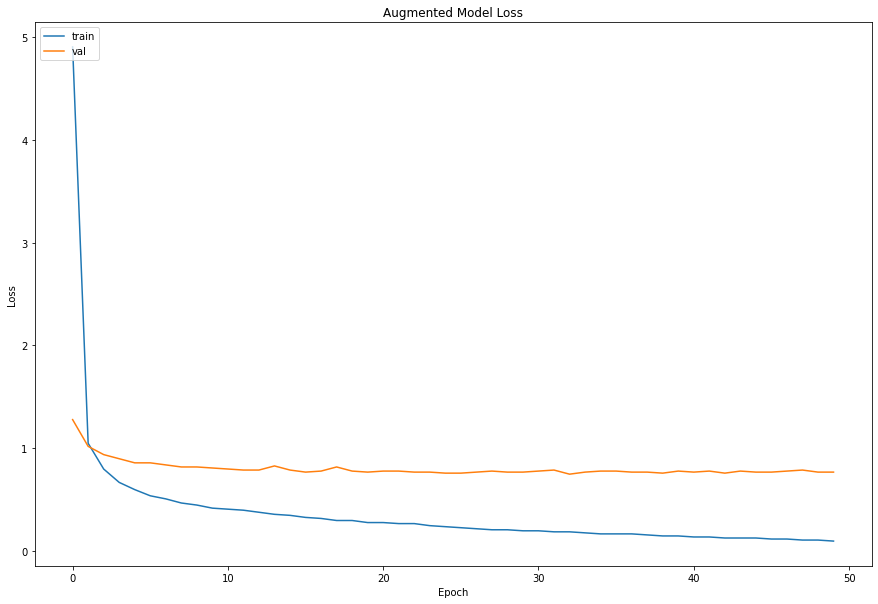

In [295]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['train']['loss'])
plt.plot(train_history['val']['loss'])
plt.title('Augmented Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [296]:
# Run testing
test_acc, test_loss = run_testing(aug_model, test_iterator, criterion, 'sick.pt')

Test Loss: 0.720 | Test Acc: 89.17%


### Visualización

In [297]:
import numpy as np
from sklearn.manifold import TSNE

# Display 2D mapping for sentence features
def show_clusters():
    pass

#X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
#X_embedded = TSNE(n_components=2).fit_transform(X)
#X_embedded.shape

## Referencias

[1] Sentiment Analysis en Pytorch: https://github.com/bentrevett/pytorch-sentiment-analysis

[2] Text Classification en Pytorch: https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch

[3] J. Mueller, A. Thyagarajan. Siamese Recurrent Architectures for Learning Sentence Similarity. In AAAI-16 2016.

[4] Implementación de Manhattan LSTM: https://github.com/fionn-mac/Manhattan-LSTM

[5] Data Augmentation en NLP: https://maelfabien.github.io/machinelearning/NLP_8/#data-augmentation-techniques

[6] TSNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html